# PacBio 2019 Alzheimer Sequel2 dataset

This notebook demonstrates the data preprocessing, import and basic vizualization of genes with Sashimi plots. 

## Preparation
1) Prepare the working directory and download the reference and data
``` bash
    cd /my/working/directory
    # create some subdirectories
    mkdir -p reference alzheimer/flnc alzheimer/aligned alzheimer/pickle tables plots
    
    # download a reference genome (806 MB)
    genome_link='ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/GRCh38.p13.genome.fa.gz'
    wget -P reference/ -O GRCh38.p13.genome.fa.gz ${genome_link} 
    gunzip reference/GRCh38.p13.genome.fa.gz
    
    # download gencode reference annotation (46.2 MB)
    gff='gencode.v36.chr_patch_hapl_scaff.annotation'
    annotation_link= ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/${gff}.gff3.gz
    wget -P reference/ ${annotation_link} 
    
    # sort by chromosome and position
    (zcat ${gff}.gff3.gz| grep ^"#" ; zcat reference/${gff}.gff3.gz|grep -v ^"#"| sort -k1,1 -k4,4n)|bgzip  > reference/${gff}_sorted.gff3.gz
    # create index
    tabix -p gff reference/${gff}_sorted.gff3.gz
    
    # download the isoseq flnc data (4.1 GB)
    isoseq_link='https://downloads.pacbcloud.com/public/dataset/Alzheimer2019_IsoSeq/FullLengthReads/flnc.bam'
    wget -P alzheimer/flnc -O alzheimer2019_isoseq_flnc.bam ${isoseq_link} 
```

2) Align the isoseq data to the reference genome using minimap2.
If the pacbio isoseq3 workflow is [installed](https://github.com/PacificBiosciences/IsoSeq_SA3nUP/wiki/Tutorial:-Installing-and-Running-Iso-Seq-3-using-Conda) you can use the pacbio version of minimap2 as follows:

``` sh
    #activate the isoseq3 environement (assuming it is called pacbio)
    conda activate pacbio
    n_threads=60
    sample='alzheimer2019_isoseq'
    ref='reference/GRCh38.p13.genome.fa'
    pbmm2 align ${ref} alzheimer/flnc/${sample}_flnc.bam alzheimer/aligned/${sample}_aligned.sorted.bam --preset ISOSEQ --sort -j $n_threads 
```



## Data import

In [1]:
import isotools
print(f'This is isootools version {isotools.__version__}')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')


This is isootools version 0.2.6


In [2]:
sample='alzheimer2019_isoseq'
bam=f'alzheimer/aligned/{sample}_aligned.sorted.bam'
genome='reference/GRCh38.p13.genome.fa'
anno='reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted'



In [3]:

try:
    #try to restore previously prepared data (about 2 minutes)
    isoseq=isotools.Transcriptome(f'alzheimer/pickle/{sample}_isotools.pkl')
except FileNotFoundError:
    try:
        #try to restore the reference
        isoseq=isotools.Transcriptome.from_reference(anno+'.isotools.pkl')
    except FileNotFoundError:
        #import the reference from gff3 (3 minutes)
        isoseq=isotools.Transcriptome.from_reference(anno+'.gff3.gz') 
        # save the reference, so it it can be reused for other datasets/analysis
        isoseq.save_reference(anno+'.isotools.pkl') 
    # import the long read data and compare to reference (only one sample for this dataset, takes 30-40 minutes)
    isoseq.add_sample_from_bam(bam, sample_name='alzheimer_1', group='alzheimer', min_align_fraction=0) 
    # compute QC metrics for all transcripts
    isoseq.add_qc_metrics(genome) #takes 15-20 min
    # update the index for fast gene access by name/id
    isoseq.make_index()
    # save the current data
    isoseq.save(f'alzheimer/pickle/{sample}_isotools.pkl')


INFO:loading transcriptome from alzheimer/pickle/alzheimer2019_isoseq_isotoolsXX.pkl
INFO:importing reference from pkl file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotoolsXX.pkl
INFO:importing reference from gff3 file reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.gff3.gz
3270946it [01:59, 27411.33it/s]
INFO:skipped the following categories: {'five_prime_UTR', 'three_prime_UTR', 'stop_codon_redefined_as_selenocysteine', 'CDS'}
INFO:saving reference to reference/gencode.v36.chr_patch_hapl_scaff.annotation_sorted.isotools.pkl
INFO:adding sample alzheimer_1 from file alzheimer/aligned/alzheimer2019_isoseq_aligned.sorted.bam
100%|██████████| 4411279.0/4411279 [29:41<00:00, 2476.13reads/s, chr=KI270757.1] 
INFO:ignoring 117136 chimeric alignments with less than 2 reads
INFO:imported 4131037 nonchimeric reads (including  22068 chained chimeric alignments) and 27006 chimeric reads with coverage of at least 2.
100%|██████████| 312879/312879 [08:40<00:00, 601

## Saturation Anlalysis
To estimate the saturation of discovered isoforms, IsoTools offers two complimentary figures: 
* The saturation plot models the expected probability of discovering a transcript 
    * at given level of confidence (number of supporting long reads) 
    * which is present at a given abundance level in the sample (in transcripts per milion, TPM)
    * depending on the total number of long reads
* The rarefaction analysis depicts the number of different discovered transcripts when subsampling the long reads

The saturation analysis reveals that at the given sequencing depth, transcripts expressed at 1 TPM have about 90% probability of beeing covered by at least two reads in the individual samples, while transcripts expressed at 0.5 TPM have 60% probability. The slope of the rarefaction curve at the right end reflects the number of novel transcripts that could be discovered if sequencing depth would be increased. 

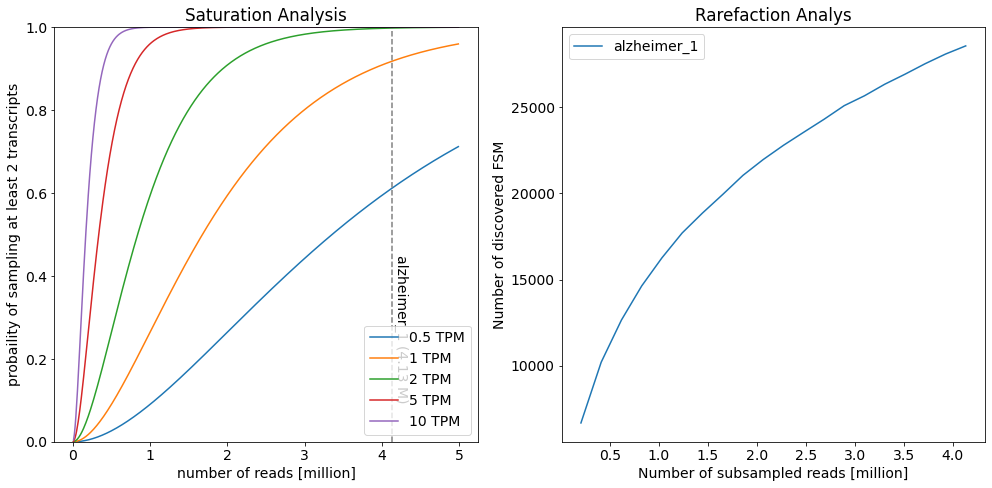

In [11]:
from isotools.plots import plot_saturation
plt.rcParams["figure.figsize"] = (14,7)
fig, axs=plt.subplots(1,2)

plot_saturation(isoseq,cov_th=2, x_range=(1e4,5e6,1e4), ax=axs[0])

rarefraction=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
for sa in isoseq.samples:
    total=isoseq.sample_table.nonchimeric_reads[isoseq.sample_table.name==sa]
    axs[1].plot([f*total/1e6 for f in rarefraction.index],rarefraction[sa], label=sa)
axs[1].legend()
axs[1].set_title('Rarefaction Analys')
axs[1].set_ylabel('Number of discovered FSM')
axs[1].set_xlabel('Number of subsampled reads [million]')
fig.tight_layout()

## Quality control and filtering
Isotools allows to filter genes and transcripts based on user defined criteria. This is helpful e.g. to mark potential artefacts. Isotools comes with some default criteria, stored in key value pairs (in dicts), where the key is a tag (single word in ALLCAPS) and the value is an expression, that gets evaluated on the properties of the gene or transcript.
There are three sets of criteria, one evalutated in gene context, one for transcripts, and one for reference transcripts. 
For example, the expression for INTERNAL_PRIMING flag is 'len(exons)==1 and downstream_A_content and downstream_A_content>.5', e.g. it selects (e.g. returns TRUE) mono exon genes with more than 50% A downstream of the transcript. 
These tags, or a boolian expression including multiple tags, can be used in "queries" to filter reads.

Users can modify existing criteria, for example to adjust thresholds, or define additional criteria, based on custom properties. 

The following example shows how the user can define additional flags, in this case "HIGH_SUPPORT" and "PROTEIN_CODING" for the reference transcripts, which is based on the GENCODE annotation information on "transcript_support_level" and "transcript_type". 

As additional examples, we print all the default definitions.

In [6]:
#add gencode specific filters in "reference" context

isoseq.add_filter( "HIGH_SUPPORT", 'transcript_support_level=="1"', context='reference')
isoseq.add_filter( "PROTEIN_CODING", 'transcript_type=="protein_coding"', context='reference')

#print all defined filter expressions
for context in isoseq.filter:
    print(f'\n{context}\n{"="*len(context)}')
    for tag,expression in isoseq.filter[context].items():
        print(f'- {tag}:\t{expression}')



gene
====
- NOVEL_GENE:	not reference
- EXPRESSED:	transcripts
- CHIMERIC:	chimeric

transcript
- INTERNAL_PRIMING:	len(exons)==1 and downstream_A_content and downstream_A_content>.5
- RTTS:	noncanonical_splicing is not None and novel_splice_sites is not None and any(2*i in novel_splice_sites and 2*i+1 in novel_splice_sites for i,_ in noncanonical_splicing)
- NONCANONICAL_SPLICING:	noncanonical_splicing
- NOVEL_TRANSCRIPT:	annotation[0]>0
- FRAGMENT:	fragments and any("novel exonic " in a or "fragment" in a for a in annotation[1])
- UNSPLICED:	len(exons)==1
- MULTIEXON:	len(exons)>1
- SUBSTANTIAL:	g.coverage.sum() * .05 < g.coverage[:,trid].sum()
- ANTISENSE:	"antisense" in annotation[1]
- INTERGENIC:	"intergenic" in annotation[1]
- GENIC_GENOMIC:	"genic genomic" in annotation[1]
- NOVEL_EXONIC_PAS:	"novel exonic PAS" in annotation[1]
- NOVEL_INTRONIC_PAS:	"novel intronic PAS" in annotation[1]
- READTHROUGH_FUSION:	"readthrough fusion" in annotation[1]
- NOVEL_EXON:	"novel exon" in an

To demonstrate the use of the filter queries, we compute some summary statistics based on subsets of the transcripts. 
* For the trasncript length distribution 
    * we select all transcripts where the NOVEL_GENE expression evaluates to FALSE (should be same as "
    * For the reference annotation, only transcripts with HIGH support are selected. 
* The A content downstream of the gene is interesting for novel unspliced genes ("NOVEL and UNSPLICED"), contrasted with full splice reference matching transcripts ("FSM")
* The length distribution of direct repeats is computed for known, novel canonical, and novel noncanonical splice junctions. This is done for all transcripts, as we do not define a query here. 

In [7]:
#compute some summary statistics on technical artifacts. 
tr_stats=[
    isoseq.transcript_length_hist(groups=isoseq.groups(), add_reference=True, min_coverage=2,tr_filter=dict( query='not NOVEL_GENE'), ref_filter=dict(query='HIGH_SUPPORT')),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict( query='FSM'), ref_filter=dict(query='not REF_UNSPLICED')),
    isoseq.downstream_a_hist(groups=isoseq.groups(), tr_filter=dict(query='NOVEL_GENE and UNSPLICED')),
    isoseq.direct_repeat_hist(groups=isoseq.groups(),bins=np.linspace(-.5,10.5,12))]

tr_stats.append((pd.concat([tr_stats[1][0].add_suffix(' known'),tr_stats[2][0].add_suffix(' novel')]),tr_stats[2][1]))


We can depict the summary statistics on the quality control metrics and filter flags.
Isotools distinguishes 3 main types of artefacts:

* **Internal priming**, where the primer binds genomic stretches of high adenosine content, yielding apparent novel genes which are typically unspliced. 
* **Reverse transcriptase template switching (RTTS)**, resulting in apperant novel introns, often without canonical splice sites.
* **Truncated fragments**, of transcripts, yielding apperant novel transcription start sites or polyA sites.

In [8]:

#statistic on the filter flags
f_stats=isoseq.filter_stats( weight_by_coverage=True,min_coverage=1, tags=['INTERNAL_PRIMING', 'RTTS', 'FRAGMENT'])
f_stats[0].index=f_stats[0].index.str.replace('_','\n')

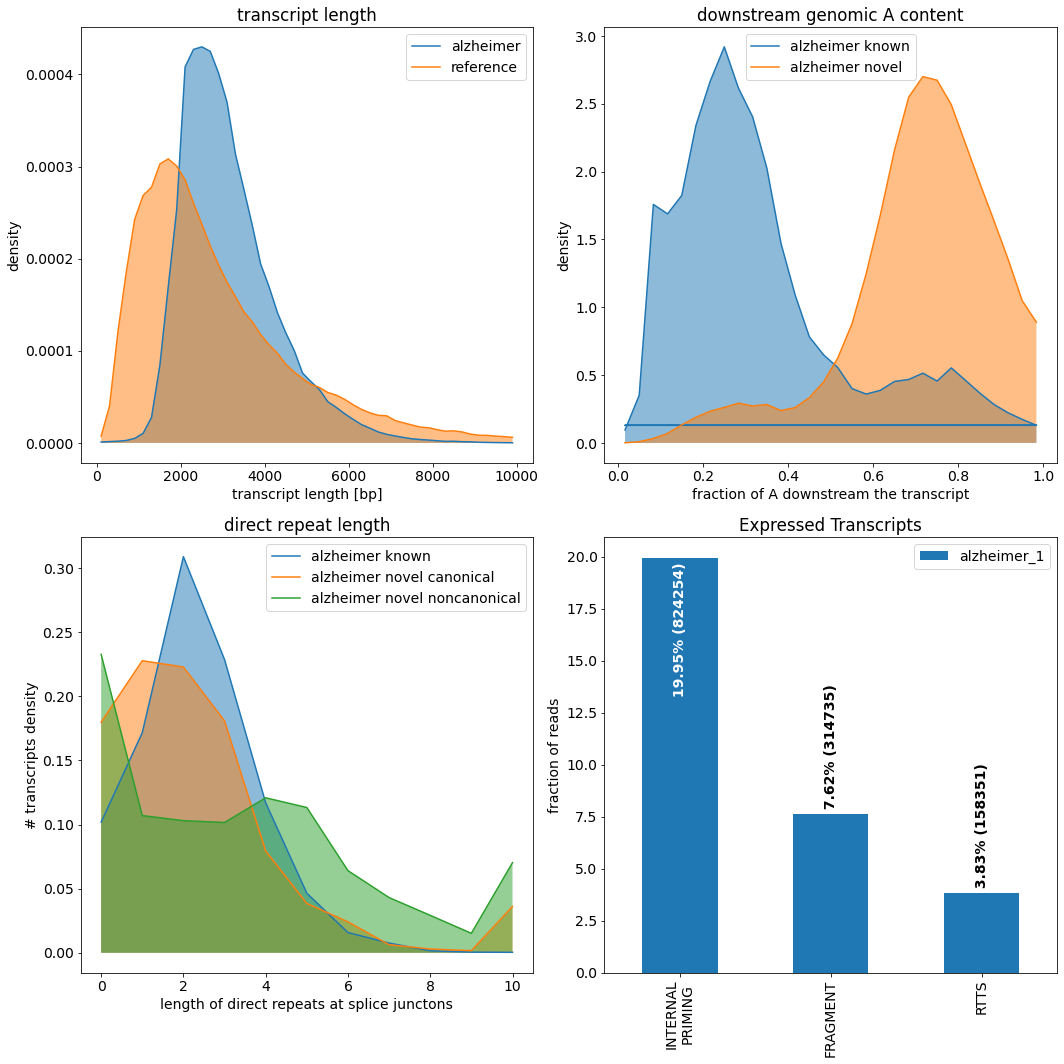

In [9]:
#QC plot
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 14})


fig, axs = plt.subplots(2,2)
#A) transcript length
plot_distr(tr_stats[0][0],smooth=3,ax=axs[0,0],**tr_stats[0][1])  
#B) internal priming
plot_distr(tr_stats[4][0],smooth=3,ax=axs[0,1],density=True,fill=True, **tr_stats[4][1])  
#C) RTTS
plot_distr(tr_stats[3][0],ax=axs[1,0],density=True,**tr_stats[3][1])  
#D) frequency of artifacts
plot_bar(f_stats[0],ax=axs[1,1],drop_categories=['PASS' ],**f_stats[1])  

fig.tight_layout()


This particular dataset seems to have relativly high fraction of internal priming, affecting 20% of the full lenght reads. 

## Novel alternative splicing classification
In order to assess the types of novel transcripts, isotools extends the SQANTI classification scheme (FSM, ISM, NIC, NNC, novel gene) by subcategories, that facilitate direct biological interpretation. 

The following  artificial example exemplifies the different subcategories. In the original state, it covers all subcategories (except categories for novel genes). However, users are encouraged to modify the examples, in order to explore edge cases, combinations and other specific cases.
The labels in the plots produced below reflect the subcategories assigned by isoseq.

FSM: {'FSM': [0, 2]}
5' fragment: {"5' fragment": [[12, 33]]}
3' fragment: {"3' fragment": [[55, 80]]}
mono exon: {'mono-exon': []}
exon skipping: {'exon skipping': [[30, 40]]}
intron retention: {'intron retention': [(20, 30)]}
novel combination: {'novel combination': []}
novel junction: {'novel junction': [[60, 75]]}
novel exonic TSS: {'novel exonic TSS': [(26, 30)]}
novel exonic PAS: {'novel exonic PAS': [(60, 66)]}
novel 5' splice site: {"novel 5' splice site": [(24, -4)]}
novel 3' splice site: {"novel 3' splice site": [(26, 4)]}
novel exon: {'novel exon': [[43, 47]]}
novel intronic TSS: {'novel intronic TSS': [[43, 47]]}
novel intronic PAS: {'novel intronic PAS': [[82, 90]]}


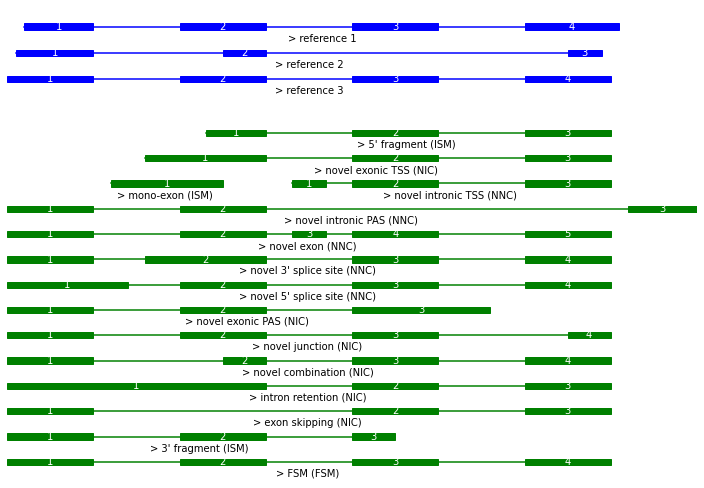

In [8]:
ref=[[[12,20],[30,40], [50,60],[70,81]],
     [[11,20],[35,40],         [75,79]],
     [[10,20],[30,40], [50,60],[70,80]]]
novel={'FSM':         [[10,20],[30,40], [50,60],[70,80]],
       "5' fragment": [[33,40], [50,60],[70,80]],
       "3' fragment": [[10,20],[30,40], [50,55]],
       "mono exon"  : [[22,35]],
       "exon skipping"     :  [[10,20], [50,60],[70,80]],
       "intron retention"  :  [[10,40], [50,60],[70,80]],
       "novel combination" :  [[10,20],[35,40], [50,60],[70,80]],
       "novel junction"  :   [[10,20],[30,40], [50,60], [75,80]],
       "novel exonic TSS"  :  [[26,40], [50,60],[70,80]],
       "novel exonic PAS"  :  [[10,20],[30,40], [50,66]],
       "novel 5' splice site":[[10,24],[30,40], [50,60],[70,80]],
       "novel 3' splice site":[[10,20],[26,40], [50,60],[70,80]],
       "novel exon"  :        [[10,20],[30,40],[43,47], [50,60],[70,80]],
       "novel intronic TSS" : [[43,47],[50,60],[70,80]],
       "novel intronic PAS" : [[10,20],[30,40], [82,90]]}
ref={'transcripts':[{'exons':e, 'transcript_name':f'reference {i+1}'} for i,e in enumerate(ref)]}
transcripts=[{'exons':e, 'transcript_name':n} for n,e in novel.items()]
example=isotools.Gene(10,80,{'strand':'+','ID':'example','reference':ref, 'transcripts':transcripts},None)
f,axs=plt.subplots(2,figsize=(10,7), gridspec_kw={'height_ratios': [1, 4]})
cat=['FSM','ISM','NIC','NNC','novel gene']
sg=example.ref_segment_graph
for novel in example.transcripts:
    alt_splice=sg.get_alternative_splicing(novel['exons'])
    print(f"{novel['transcript_name']}: {alt_splice[1]}")
    novel['transcript_name']=f"{','.join(alt_splice[1])} ({cat[alt_splice[0]]}) "
    
example.gene_track(ax=axs[0], x_range=[10,90], title='')
example.gene_track(reference=False,ax=axs[1], x_range=[10,90], title='', color='green')  
for ax in axs:
    ax.get_xaxis().set_visible(False)
f.tight_layout()


During import, all isoseq transcripts get classified using this scheme. 
We can depict the number of identified novel classes. 
Note the query we use to filter out transcripts affected by one of the 3 artefacts.

In [9]:

cnr={}
for g, trid, tr in isoseq.iter_transcripts():
    for anno in tr['annotation'][1]:
        cnr[anno]=min(cnr.get(anno,5),tr['annotation'][0])
del cnr['FSM']
altsplice=[ isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=1, tr_filter=dict( query="not( RTTS or FRAGMENT or INTERNAL_PRIMING)")),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=True, min_coverage=2, tr_filter=dict( query="not( RTTS or FRAGMENT or INTERNAL_PRIMING)")),
            isoseq.altsplice_stats(groups=isoseq.groups(), weight_by_coverage=False, min_coverage=20, tr_filter=dict( query="not( RTTS or FRAGMENT or INTERNAL_PRIMING)"))]
for i in range(3):
    altsplice[i][0].index=altsplice[i][0].index+[f'\n({cat[cnr[subcat]]})' if subcat in cnr else '' for subcat in altsplice[i][0].index]
    altsplice[i][0].index=altsplice[i][0].index.str.replace('splice ','\nsplice ')

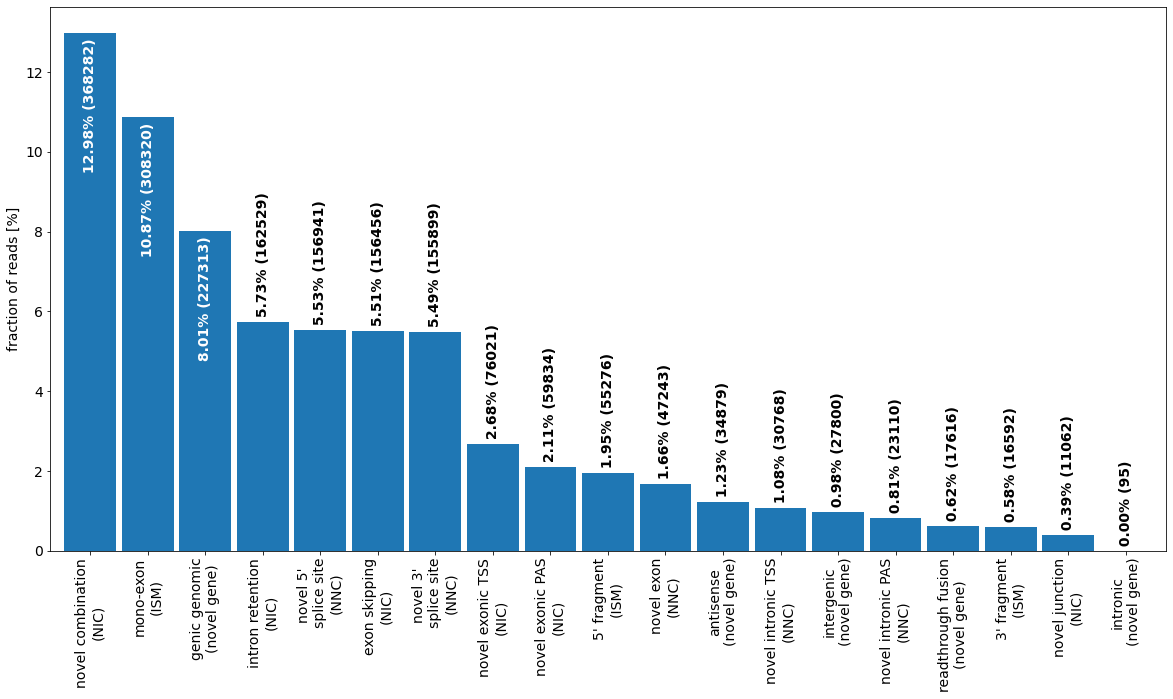

In [10]:
from isotools.plots import plot_bar, plot_distr

plt.rcParams["figure.figsize"] = (20,10)
_=plot_bar(altsplice[0][0],bar_width=.9,ylabel='fraction of reads [%]', legend=False, rot=90,drop_categories=['FSM'])  


## Data exploration
This cell provides some examples, how the data can be assessed in isotools, and what information is stored on gene and transcript level. As an example, we focus on the 'MAPT' gene, which features alternative splicing and is related to Alzheimer's disease. 

In [11]:
#access gene of interest by Name
g=isoseq['MAPT']
print(g)
#this reveals that the MAPT has 267 different variants, according to isoseq. 
total_cov=g.coverage.sum()
#However, most are supported by few reads only
print(f'{sum([cov>total_cov *.01 for cov in g.coverage][0])} transcripts contribute at least 1% to that gene')
#lets look at the primary transcript
max_i=np.argmax(g.coverage)
print(f'The primary transcript is number {max_i} and contributes {g.coverage[0,max_i]/total_cov:.2%}  ({g.coverage[0,max_i]}/{total_cov})')
#all the information for this transcript are stored in this dict:
primary=g.transcripts[max_i]
print(f'\nThese are the infos for this transcript:')
for k,v in primary.items():
    print(f'{k}: {str(v)[:100]}{"..." if len(str(v))>100 else ""}')
# this reveals that it is a mono exon in the 3'UTR of that gene.
second_i=np.argsort(g.coverage[0])[-2]
second=g.transcripts[second_i]
print(f'\nThese are the infos for the second transcript:')
for k,v in second.items():
    print(f'{k}: {str(v)[:100]}{"..." if len(str(v))>100 else ""}')

# this reveals that it is a FSM with reference transcript nr 7.

print(f'\nThe corresponding reference transcript: ')
for k,v in g.ref_transcripts[second["annotation"][1]["FSM"][0]].items():
    print(f'{k}: {str(v)[:100]}{"..." if len(str(v))>100 else ""}')


Gene MAPT chr17:45894550-46028334(+), 16 reference transcripts, 272 expressed transcripts
10 transcripts contribute at least 1% to that gene
The primary transcript is number 265 and contributes 22.42%  (601/2681)

These are the infos for this transcript:
exons: [[46025876, 46028330]]
strand: +
TSS: {'alzheimer_1': {46022396: 3, 46022538: 1, 46022576: 1, 46022912: 1, 46023166: 1, 46023259: 2, 46023...
PAS: {'alzheimer_1': {46026081: 15, 46026077: 5, 46026082: 27, 46026083: 38, 46026079: 7, 46028330: 193, ...
coverage: {'alzheimer_1': 601}
annotation: (1, {'mono-exon': []})
fragments: [(166, 10, 0), (267, 1, 0)]
direct_repeat_len: []
downstream_A_content: 0.3333333333333333

These are the infos for the second transcript:
exons: [[45894555, 45894686], [45962320, 45962470], [45978374, 45978440], [45987039, 45987095], [45991459, ...
strand: +
TSS: {'alzheimer_1': {45894371: 2, 45894492: 1, 45894498: 1, 45894502: 1, 45894504: 1, 45894505: 1, 45894...
PAS: {'alzheimer_1': {46026081: 60, 46026

In [12]:
#we can iterate over transcripts and filter with a query:
i=0
for g,trnr,tr in isoseq.iter_transcripts(query='INTERNAL_PRIMING'):
    print(f'transcript nr {trnr} of {g} with a coverage of {g.coverage[0,trnr]}') 
    i+=1
    if i>10:
        break
    

transcript nr 0 of Gene PB_novel_245237 GL000194.1:63158-64802(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 7
transcript nr 0 of Gene PB_novel_245239 GL000194.1:67798-69577(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 2
transcript nr 0 of Gene PB_novel_245257 GL000195.1:64302-67151(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 4
transcript nr 0 of Gene PB_novel_245252 GL000195.1:51826-53921(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_245263 GL000195.1:137975-148308(+), 0 reference transcripts, 2 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_245251 GL000195.1:49455-51398(-), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_245264 GL000195.1:155779-159045(+), 0 reference transcripts, 1 expressed transcripts with a coverage of 1
transcript nr 0 of Gene PB_novel_2452

In [ ]:
#we can also iterate over transcripts and filter by region (chr[:start-end]), novelty category, or request a minimum coverage:
for g,trnr,tr in isoseq.iter_transcripts(region='chr1', include=['novel exon'], min_coverage=100):
    print(f'Gene {g.name} has a highly covered transcript with novel exon:')
    print(f'Transcript nr {trnr}  with a coverage of {g.coverage[0,trnr]}/{g.coverage.sum()}') 
    print(f'The novel exon is at position {tr["annotation"][1]["novel exon"]}') 

    

## Data vizualization
We depict the MAPT gene with its two major exon skipping events as sashimi plot.

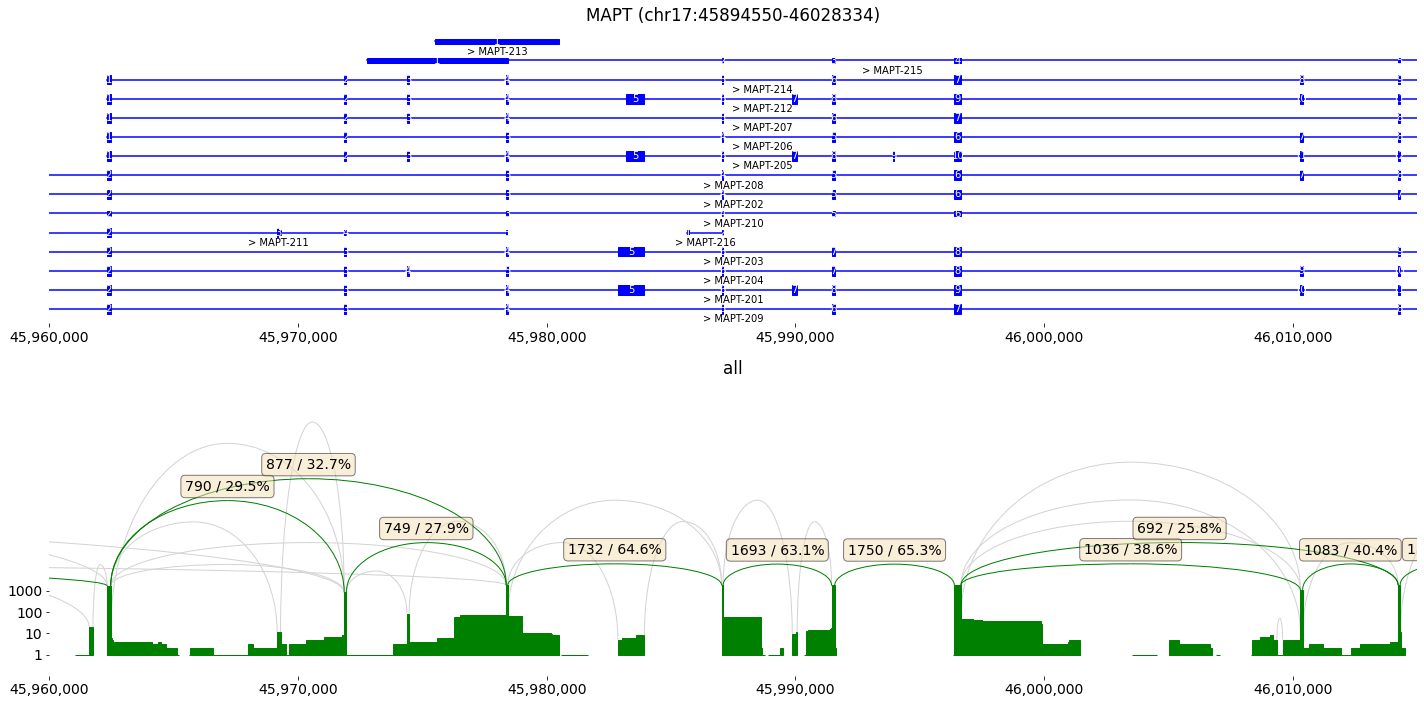

In [13]:
plt.rcParams["figure.figsize"] = (20,10)
fig,axs=isoseq['MAPT'].sashimi_figure(x_range=[45960000,46015000])
fig.tight_layout()